In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [ ]:
!pip install tensorflow==2.7.0

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Concatenate,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [5]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Text(0.5, 1.0, 'Class- T-shirt/top')

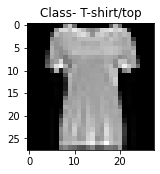

In [7]:
plt.figure(figsize=[5,5])

# Seeing what the images look like
plt.subplot(121)
curr_img = np.reshape(x_train[10], (28,28))
curr_lbl = y_train[10]
plt.imshow(curr_img, cmap='gray')
plt.title(f"Class- {label_dict[curr_lbl]}")

In [8]:
# Data Preprocessing
x_train = x_train.reshape(-1, 28,28, 1)
x_test = x_test.reshape(-1, 28,28, 1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
# Validation dtypes, range
x_train.dtype, x_test.dtype, np.max(x_train), np.max(x_test)

(dtype('uint8'), dtype('uint8'), 255, 255)

In [10]:
# Scaling
x_train = x_train / np.max(x_train)
x_test = x_test / np.max(x_test)
np.max(x_train), np.max(x_test)

(1.0, 1.0)

## Autoencoder to understand the data

In [11]:
## Spliting training data to train and validate
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=13)

In [12]:
# Basic autoenc params
batch_size = 64
epochs = 100
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [13]:
# Enc/Dec functions, we will only use the enc part for later
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
# Train the autoenc
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_70 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_72 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_71 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0   

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/100
750/750 [==============================] - 26s 29ms/step - loss: 0.0193 - val_loss: 0.0159
Epoch 2/100
750/750 [==============================] - 17s 22ms/step - loss: 0.0086 - val_loss: 0.0090
Epoch 3/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 4/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 5/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 6/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 7/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0042 - val_loss: 0.0071
Epoch 8/100
750/750 [==============================] - 13s 18ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 9/100
750/750 [==============================] - 14s 18ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/100
750/750 [==============================] - 13s 18ms/step - l

### Visualizing the training part. 
Looks good, no overfitting since both losses are going down.



<function matplotlib.pyplot.show(*args, **kw)>

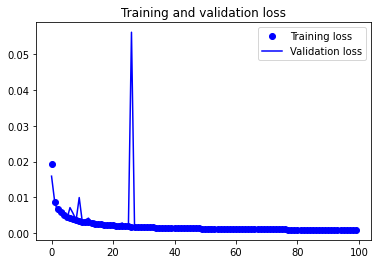

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show

In [ ]:
autoencoder.save('./models/autoencoder.h5')

## Training a classifer on top of the embeddings

In [14]:
autoencoder = load_model('./models/autoencoder.h5')

In [15]:
# OHE for labels (originally categorical)
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [38]:
## Since we have to use minimum labeled samples from training, we do it this way:
## we iterate using n (labeled) samples at a time, see how our model performs and minimize n.
## note: in the autoenc above we used all samples but we did not use any labels ;)

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

def train_classifier(n):
  """
  this fn defines the full model: encoder from autoencoder + simple classifier
  creates a new 'full_model' classifier
  the target is the class

  Input: n=the number of samples to consider in training data 
  Returns: model
  """
  assert n!=0

  #we take a total of n samples: 0.2n in test -> 0.8n in train, shuffling is handled by train_test_split
  train_X,valid_X,train_label,valid_label = train_test_split(x_train,train_Y_one_hot,train_size=int(0.8*n), test_size=int(0.2*n),random_state=13)
  
  print(np.shape(train_X), np.shape(valid_X)) #basic assert
  
  
  encode = encoder(input_img)
  full_model = Model(input_img,fc(encode))

  #set weights
  for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

  #make the trained autoenc layers untrainable, (bias + speed reasons + more)
  for layer in full_model.layers[0:19]:
    layer.trainable = False

  #compile the model
  #the only var here is the size of training data
  full_model.compile(loss=categorical_crossentropy, optimizer=Adam() ,metrics=['accuracy'])

  classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))
  full_model.save(f'./models/classification_complete_{n}.h5')
  return full_model

In [39]:
from sklearn.metrics import accuracy_score
def calculate_metrics(model):
  """
  takes in the full_model, returns loss,acc
  """
  
  # note: we could also use the eval method to calculate accuracy:
  # test_eval = model.evaluate(x_test, test_Y_one_hot, verbose=0)
  # model_loss, model_acc = test_eval[0], test_eval[1]
  # we do rounding for more accurate results

  y_pred = model.predict(x_test)
  y_pred = np.argmax(np.round(y_pred),axis=1)

  model_acc = accuracy_score(y_test, y_pred)
  return model_acc

In [40]:
minimum_labeled_samples = [100, 1000, 10000, 30000]


for n in minimum_labeled_samples:
  model = train_classifier(n)
  model_acc = calculate_metrics(model)
  with open("./results.txt", mode="a") as f:
    f.write(f"\n{n}\t{model_acc}")

(80, 28, 28, 1) (20, 28, 28, 1)
Epoch 1/100
2/2 [==============================] - 1s 263ms/step - loss: 2.7754 - accuracy: 0.1250 - val_loss: 3.7006 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 0.6400 - accuracy: 0.8250 - val_loss: 3.3915 - val_accuracy: 0.4000
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0375 - accuracy: 0.9875 - val_loss: 4.9298 - val_accuracy: 0.4500
Epoch 4/100
2/2 [==============================] - 0s 28ms/step - loss: 0.3985 - accuracy: 0.9500 - val_loss: 4.4841 - val_accuracy: 0.3500
Epoch 5/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1881 - accuracy: 0.9750 - val_loss: 3.4544 - val_accuracy: 0.3500
Epoch 6/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0116 - accuracy: 0.9875 - val_loss: 3.1451 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 3.2690 - val_accu

[[1.000e+02 6.445e-01]
 [1.000e+03 8.171e-01]
 [1.000e+04 8.860e-01]
 [3.000e+04 9.022e-01]]


<function matplotlib.pyplot.show(*args, **kw)>

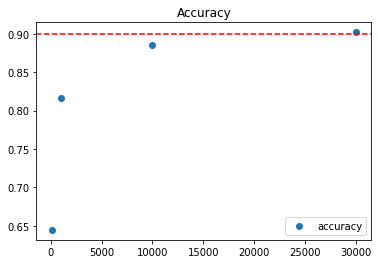

In [31]:
## Plot acc vs sample size of labeled data
with open('./results.txt', 'r') as f:
  next(f) #header
  data = [line.strip('\n').split('\t') for line in f]
  data = np.array([[float(a), float(b)] for a,b in data])
print(data)
plt.scatter(x=data[:,0], y=data[:,1], label='accuracy')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Accuracy')
plt.legend()
plt.show

### Visualizing the sample size vs accuracy, we probably have the best sample size between 15k-25k to get an accuracy of 0.9+

In [32]:
## Classification Report to check what classes are performing/under-performing
from sklearn.metrics import classification_report

full_model = load_model('./models/classification_complete_30000.h5')

predicted_classes = full_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

target_names = [f"{label_dict[i]}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.84      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.91      0.89      0.90      1000
        Coat       0.83      0.85      0.84      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.73      0.74      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [33]:
## Checking the results for 10k samples model
from sklearn.metrics import classification_report

full_model = load_model('./models/classification_complete_10000.h5')

predicted_classes = full_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

target_names = [f"{label_dict[i]}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.81      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.82      0.84      0.83      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.80      0.84      0.82      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.73      0.68      0.70      1000
     Sneaker       0.94      0.93      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Closing Notes:
1. This is just one approach to reduce the number of labeled samples needed for classification. Looking at the report for 30k samples, we see that some classes (like Shirt) are underperforming, whereas a few (like Trouser) are very good. Instead of randomly sampling from training set, if we were to carefully sample from each class, we can cut down the "n"
2. The 10k model is almost there, more tweaks to improve underperforming classes and we get 0.9 accuracy on the test set.
3. Parameter and Hyperparameter tuning should improve results further.
4. Trainable/Untrainable: with the initial layers set to trainable, the accuracy metrics are slighty better, the results are in ./other
5. I have limited experience with autoencs, this was a fun problem to work on.

In [34]:
!pip freeze > requirements.txt